6 image(s) done


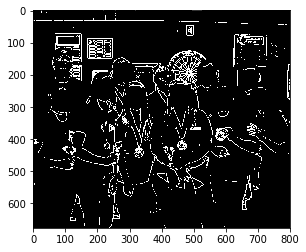

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import time

def imshow(image):
    #OpenCV stores images in BGR so we have to convert to RGB to display it using matplotlib
    imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imagergb)
    plt.show()

face_classifier = cv2.CascadeClassifier('frontalface.xml')
# face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

i = 5

location = str("../images/dart") + str(i) + str(".jpg")
imgcol = cv2.imread(location)
img = cv2.cvtColor(imgcol, cv2.COLOR_BGR2GRAY)

faces = face_classifier.detectMultiScale(img, 1.1, 20, 0, (30,30), (200,200))


if faces is ():
    print('No faces found')
# Draw box by iteration

for (x,y,w,h) in faces:
    cv2.rectangle(imgcol, (x,y), (x+w,y+h), (0,255,0), 2)


sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

(M,N) = sobelx.shape
grad = np.zeros((M,N))
direc = np.zeros((M,N))
thresh = 2*np.sum(img)/(N*M) #the higher the quicker, but risk not representing edges

for m in range (0,M): #m = y
    for n in range  (0,N): # n = x
        grad[m,n] = math.sqrt(sobelx[m,n]**2 + sobely[m,n]**2)
        if sobelx[m,n] == 0: # to prevent division by zero in direc
            sobelx[m,n]= 1*10**(-5)
        direc[m,n] = np.arctan(sobely[m,n]/sobelx[m,n])
        if grad[m,n]>thresh:
            grad[m,n] = 255
        else:
            grad[m,n] = 0


for (X,Y,W,H) in faces:
    for y in range (Y,Y+H):
        for x in range (X,X+W):
            grad[y,x] = 0

saveloc = (str("nofaceedge/dartnofaceedge" + str(i) + str(".jpg")))
cv2.imwrite(saveloc,grad)
print (str(i+1) + " image(s) done")
plt.imshow(grad, cmap='gray')


In [18]:
#Hough Circle
def HTCircle (minrad, maxrad):
    snc = minrad # rad of smallest circle: not zero to stop detection of tiny dots
    nc =  maxrad-minrad #numcir

    rad = np.zeros(nc-snc)
    for a in range (0,nc-snc):
        rad[a] = (a+snc+1)*maxrad/nc

    Hxyr = np.zeros ((M,N,nc))
    total= M*N

    deg = math.pi/180
    for m in range (0,M): #y
        for n in range (0,N): #x
            if grad[m,n] == 255:
                for r in rad:

                    # optimisation of the for loop to only cater for the top left quarter of a circle to its center
                    y0 = int(np.round(m + r*math.sin(direc[m,n])))
                    x0 = int(np.round(n + r*math.cos(direc[m,n])))

                    # to cater for noise we +/- 1 degree
                    y1 = int(np.round(m + r*math.sin(direc[m,n]+deg)))
                    x1 = int(np.round(n + r*math.cos(direc[m,n]+deg)))
                    y2 = int(np.round(m + r*math.sin(direc[m,n]-deg)))
                    x2 = int(np.round(n + r*math.cos(direc[m,n]-deg)))

                    # removing 2 if statements to speed up the loop
                    dx = 2*abs(x2-x1)
                    dy = 2*abs(y2-y1)
                    radindex = int(nc*r/maxrad -(snc+1))

                    if dy<=y0<M-dy and dx<=x0<N-dx:
                        Hxyr[y0,x0,radindex] += 1
                        Hxyr[y1,x1,radindex] += 1
                        Hxyr[y2,x2,radindex] += 1
                    else:
                        break #break to prevent unecessary calculation wiht larger r values
    return Hxyr

stime = time.time()
Hxyr = HTCircle(10,100)
etime = time.time()
print("runtime: Hough space " + str(etime-stime))

runtime: Hough space 130.96709871292114


In [22]:
#Creating Hough Space

def HSpace (Hxyr):
    (a,b,c) = Hxyr.shape #to calculate the no of elements
    Hspace = np.zeros((a,b))

    for y in range (0,a):
        for x in range (0,b):
            sum = 0
            for z in range (0,c):
                sum += Hxyr[y,x,z]
            Hspace[y,x] = sum

    #normalising the values
    norm = np.amax(Hspace)
    print (norm)
    Hspace = Hspace*255/norm
    print (np.amax(Hspace))
    return Hspace

def PlotCircle (Hxyr, Hspace, imgcol):

    (a,b) = Hspace.shape #for later to calculate the highest index of the flattened array
    argordH = Hspace.argsort(axis=None) #lists the indices in accending order of value (array is flattened)

    index = 1
    #in order to detect images with multiple dart boards, we find the top highest Hspace values that dont have 

    (y0,x0)=np.unravel_index(argordH[a*b-index], (a,b)) #unravels the flattened value back into a tuple for the nth highest
    print (Hspace[y0,x0])
    amax = Hxyr[y0,x0].shape
    argordxyr = Hxyr[y0,x0].argsort(axis=None)
    rindex = argordxyr[amax[0]*1-1]
    r = (rindex+snc+1)*maxrad/nc
    print("Radius: " + str(r))
    cv2.circle(imgcol, (x0,y0), int(r), (0,255,0), 3, cv2.LINE_AA)

    index += 1
    for c in range(index, a*b):
        (y,x)=np.unravel_index(argordH[a*b-c], (a,b)) #unravels the flattened value back into a tuple for the nth highest
        if math.sqrt((x0-x)**2 + (y0-y)**2)>50:
            index = c
            break

    (y1,x1)=np.unravel_index(argordH[a*b-index], (a,b)) #unravels the flattened value back into a tuple for the nth highest
    print (Hspace[y1,x1])
    amax = Hxyr[y1,x1].shape
    argordxyr = Hxyr[y1,x1].argsort(axis=None)
    rindex = argordxyr[amax[0]*1-1]
    r = (rindex+snc+1)*maxrad/nc
    print("Radius: " + str(r))
    cv2.circle(imgcol, (x1,y1), int(r), (0,0,255), 3, cv2.LINE_AA)

    for c in range(index, a*b):
        (y,x)=np.unravel_index(argordH[a*b-c], (a,b)) #unravels the flattened value back into a tuple for the nth highest
        if math.sqrt((x0-x)**2 + (y0-y)**2)>50 and math.sqrt((x1-x)**2 + (y1-y)**2)>50:
            index = c
            break

    (y2,x2)=np.unravel_index(argordH[a*b-index], (a,b)) #unravels the flattened value back into a tuple for the nth highest
    print (Hspace[y2,x2])
    amax = Hxyr[y2,x2].shape
    argordxyr = Hxyr[y2,x2].argsort(axis=None)
    rindex = argordxyr[amax[0]*1-1]
    r = (rindex+snc+1)*maxrad/nc
    print("Radius: " + str(r))
    cv2.circle(imgcol, (x2,y2), int(r), (255,0,0), 3, cv2.LINE_AA)

stime = time.time()
Hspace = HSpace(Hxyr)
print ("Hough Space Runtime: " + str(time.time()-stime))
imgcol = cv2.imread(location)
PlotCircle(Hxyr, Hspace, imgcol)

295.0
255.0
Hough Space Runtime: 12.163924932479858
255.0
Radius: 29.0
109.77966101694915
Radius: 21.0
101.13559322033899
Radius: 12.0


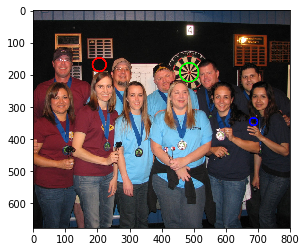

In [23]:
imshow(imgcol)